# Training BatchNorm and only BatchNorm on Graphs
-------------------------------------------------------
In this project we test experimentally how it is possible to obtain good results by training only the parameters of batch normalization on non-Euclidean data such as graphs.

The chosen problem was Graph Classification for discern fake news from real news. 

The dataset used is the UPFD Dataset (User Preference-aware Fake News Detection) dataset, from the [paper](https://arxiv.org/abs/2104.12259) of the same name. 

Traditional methods for detecting fake news is fact-checking that required time-consuming work for acquire evidence from domain experts.

In the above-mentioned work instead, user preferences (personality, sentimentent and stance) are used together with the propagation graph of the news, in addition to the textual content of the news.
The user's preference are estimated by looking at the historical posts.
News propagation graph is build on the chain of retweets of a news.

The result is to model **each news as a tree-graph** where:
-  the root-node of the graph contains the news content 
-  the other nodes contain the users historical posts who retweeted the news.
-  An direct edge exists from node *A* to node *B* if user *B* has retweeted the news from user *A*  





## Import and reproducibility 

In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn import Linear
from torch.nn.parameter import Parameter
import torch_geometric
from torch_geometric.datasets import UPFD
from torch.nn.modules.module import Module
from torch_geometric.transforms import BaseTransform, Compose, NormalizeFeatures,ToUndirected
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected
import argparse
import matplotlib.pyplot as plt 
from tqdm import tqdm
import seaborn as sns
import utils_functions

In [2]:
seed = 1997
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cpu


## Data Loading 

In [4]:
args = argparse.Namespace()
args.PATH = "data"
args.NAME = "politifact"
args.FEATURE = "content"
args.BATCH_SIZE = 31
histories = {}

In [5]:
""" 
Load the train, validation and test datasets and dataloaders. 
"""

path = "data" 
train_dataset = UPFD(path, args.NAME, args.FEATURE, 'train')
val_dataset = UPFD(path, args.NAME, args.FEATURE, 'val')
test_dataset = UPFD(path, args.NAME, args.FEATURE, 'test')

print("len train_dataset:", len(train_dataset))
print("len val_dataset:", len(val_dataset))
print("len test_dataset:", len(test_dataset))

train_loader = DataLoader(train_dataset,
                           batch_size=args.BATCH_SIZE, 
                           shuffle=True,
                           )
val_loader = DataLoader(val_dataset,
                           batch_size=len(val_dataset), 
                           shuffle=True,
                           
                           )
test_loader = DataLoader(test_dataset,
                           batch_size=len(test_dataset), 
                           shuffle=True,
                           )


len train_dataset: 62
len val_dataset: 31
len test_dataset: 221


## Network 
-------------------------------------
The implemented model is given by a simple 2-layer Graph Convolution Network with BatchNorm.

 The news-graph passes through these levels and at the end there is a pooling level that extracts an *embedding vector* for each news-graph. The *embedding vector* passes through two levels of MLP, the last one has two outputs that can be interpreted as probabilities of true or false news.

It is worth mentioning a nice trick, similar to a residual connection, implemented in the original [paper](https://arxiv.org/abs/2104.12259), which improves the results: 

since the root of the graph contains the news text (encoded by some NLP model) it provides an important signal as to whether the news is true or false. Then, after the graph-news has traversed the pooling layer and the *embedding vector* has been extracted, the *root vector* is concatenated to the *embedding vector*. 

Finally the latter is passed through MLP layers.  



In [6]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 concat=True):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = torch_geometric.nn.BatchNorm(in_channels=hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.norm2 = torch_geometric.nn.BatchNorm(in_channels=hidden_channels)
        self.act = torch.nn.ReLU()
        if self.concat:
            self.lin0 = Linear(in_channels, hidden_channels)
            self.lin1 = Linear(2 * hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = self.norm1(h)
        h = self.act(h)
        h = self.conv2(h, edge_index)
        h = self.norm2(h)
        h = self.act(h)
        h = global_max_pool(h, batch)

        if self.concat:
            # Get the root node (tweet) features of each graph:
            root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
            root = torch.cat([root.new_zeros(1), root + 1], dim=0)
            news = x[root]

            news = self.lin0(news).relu()
            h = self.lin1(torch.cat([news, h], dim=-1)).relu()

        h = self.lin2(h)
        return h.log_softmax(dim=-1)



In [8]:
model_size_history = {}

### 1) Train all the network parameters

In [9]:
args.MODE = "ALL"
args.HIDDEN_CHANNEL = 64

model_size_history[args.MODE] = {}
model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"] = []
model_size_history[args.MODE]["TEST_ACCURACY"] = []

model = Net(train_dataset.num_features, args.HIDDEN_CHANNEL,
            train_dataset.num_classes, concat=True).to(device)
print(model)
print()


if args.MODE == "only_BN_FC":
    """Freeze all parameters, but the Batch Norm layers and the last linear layer."""
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 


    for param in model.norm2.parameters():
        param.requires_grad = True

    for param in model.lin2.parameters():
        param.requires_grad = True 

if args.MODE == "only_BN":
    """Freeze all parameters, but the Batch Norm layers."""
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 


    for param in model.norm2.parameters():
        param.requires_grad = True

 
print("Layer", "# parameters")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, ":",param.numel()) 

print()
print("Total number of parameters:", utils_functions.count_parameters(model))

Net(
  (conv1): GCNConv(310, 64)
  (norm1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (norm2): BatchNorm(64)
  (act): ReLU()
  (lin0): Linear(in_features=310, out_features=64, bias=True)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

Layer # parameters
conv1.bias : 64
conv1.lin.weight : 19840
norm1.module.weight : 64
norm1.module.bias : 64
conv2.bias : 64
conv2.lin.weight : 4096
norm2.module.weight : 64
norm2.module.bias : 64
lin0.weight : 19840
lin0.bias : 64
lin1.weight : 8192
lin1.bias : 64
lin2.weight : 128
lin2.bias : 2

Total number of parameters: 52610


In [ ]:
args.weight_decay = 0.01
args.LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, weight_decay=args.weight_decay)
model_desc = str(vars(args))

In [ ]:
loss_train_history = []
loss_valid_history = []
acc__train_history = []
acc__valid_history = []
acc__test__history = []

NUMS_EPOCHS = 1000   
for epoch in range(1, NUMS_EPOCHS):
    loss = utils_functions.train(train_loader,model, optimizer,device)
    train_acc = 100 * utils_functions.test(train_loader,model,device)
    val_acc = 100 * utils_functions.test(val_loader,model,device)
    test_acc = utils_functions.test(test_loader,model,device)
    val_loss = utils_functions.compute_val_loss(val_loader,model,device)
    print(f'Epoch: {epoch:02d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    loss_train_history.append(loss)
    loss_valid_history.append(val_loss)
    acc__train_history.append(train_acc)
    acc__valid_history.append(val_acc)
    acc__test__history.append(test_acc)

In [ ]:
## save results 
model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"].append(args.HIDDEN_CHANNEL)
model_size_history[args.MODE]["TEST_ACCURACY"].append(acc__test__history[-1])

histories[args.MODE] = {
    "args":args, 
    "loss_train_history":loss_train_history,
    "loss_valid_history":loss_valid_history,
    "acc__valid_history":acc__valid_history,
    "acc__test__history":acc__test__history,
    }

#### 2) Training only BatchNorm

Training only BatchNorm parameters means training only less then 1% of the parameters of the network. 

In [50]:
for HIDDEN_CHANNEL in [16,32,64,128]:
    model = Net(train_dataset.num_features, HIDDEN_CHANNEL,
                train_dataset.num_classes, concat=True).to(device)
    
    for param in model.parameters():
        param.requires_grad = True
    
    ## number of parameters when all parameters are trainable 
    params_all = utils_functions.count_parameters(model)

    ## number of parameters when only BN + last layer are trainable 
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 

    for param in model.norm2.parameters():
        param.requires_grad = True

    params_mode2 = utils_functions.count_parameters(model)

    print("Hidden size:",HIDDEN_CHANNEL, 
          "    Total # of params:",params_all, 
          "    # of params. training only BN:", params_mode2, 
          "    Ratio: %.2f"%((params_mode2/params_all)*100),"%")

Hidden size: 16     Total # of params: 10850     # of params. training only BN: 64     Ratio: 0.59 %
Hidden size: 32     Total # of params: 23234     # of params. training only BN: 128     Ratio: 0.55 %
Hidden size: 64     Total # of params: 52610     # of params. training only BN: 256     Ratio: 0.49 %
Hidden size: 128     Total # of params: 129794     # of params. training only BN: 512     Ratio: 0.39 %


In [24]:
args.weight_decay = 0.01
args.LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, weight_decay=args.weight_decay)

model_desc = str(vars(args))

In [246]:
loss_train_history = []
loss_valid_history = []
acc__train_history = []
acc__valid_history = []
acc__test__history = []

In [ ]:
NUMS_EPOCHS = 1000   
for epoch in range(1, NUMS_EPOCHS):
    loss = utils_functions.train(train_loader,model, optimizer,device)
    train_acc = 100 * utils_functions.test(train_loader,model,device)
    val_acc = 100 * utils_functions.test(val_loader,model,device)
    test_acc = utils_functions.test(test_loader,model,device)
    val_loss = utils_functions.compute_val_loss(val_loader,model,device)
    print(f'Epoch: {epoch:02d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    loss_train_history.append(loss)
    loss_valid_history.append(val_loss)
    acc__train_history.append(train_acc)
    acc__valid_history.append(val_acc)
    acc__test__history.append(test_acc)

In [255]:
## save results 
model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"].append(args.HIDDEN_CHANNEL)
model_size_history[args.MODE]["TEST_ACCURACY"].append(acc__test__history[-1])

histories[args.MODE] = {
    "args":args, 
    "loss_train_history":loss_train_history,
    "loss_valid_history":loss_valid_history,
    "acc__valid_history":acc__valid_history,
    "acc__test__history":acc__test__history,
    }

#### 3) Training only BatchNorm + Final Layer

In [10]:
for HIDDEN_CHANNEL in [16,32,64,128]:
    model = Net(train_dataset.num_features, HIDDEN_CHANNEL,
                train_dataset.num_classes, concat=True).to(device)
    
    for param in model.parameters():
        param.requires_grad = True
    
    ## number of parameters when all parameters are trainable 
    params_all = utils_functions.count_parameters(model)

    ## number of parameters when only BN + last layer are trainable 
    for param in model.parameters():
        param.requires_grad = False

    for param in model.norm1.parameters():
        param.requires_grad = True 

    for param in model.norm2.parameters():
        param.requires_grad = True

    for param in model.lin2.parameters():
        param.requires_grad = True 

    params_mode2 = utils_functions.count_parameters(model)

    print("Hidden size:",HIDDEN_CHANNEL, 
          "    Total # of params:",params_all, 
          "    # of params. training only BN+LIN:", params_mode2, 
          "    Ratio: %.2f"%((params_mode2/params_all)*100),"%")

Hidden size: 16     Total # of params: 10850     # of params. training only BN+LIN: 98     Ratio: 0.90 %
Hidden size: 32     Total # of params: 23234     # of params. training only BN+LIN: 194     Ratio: 0.83 %
Hidden size: 64     Total # of params: 52610     # of params. training only BN+LIN: 386     Ratio: 0.73 %
Hidden size: 128     Total # of params: 129794     # of params. training only BN+LIN: 770     Ratio: 0.59 %


In [ ]:
args.weight_decay = 0.01
args.LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, weight_decay=args.weight_decay)

model_desc = str(vars(args))

In [ ]:
NUMS_EPOCHS = 1000   
for epoch in range(1, NUMS_EPOCHS):
    loss = utils_functions.train(train_loader,model, optimizer,device)
    train_acc = 100 * utils_functions.test(train_loader,model,device)
    val_acc = 100 * utils_functions.test(val_loader,model,device)
    test_acc = utils_functions.test(test_loader,model,device)
    val_loss = utils_functions.compute_val_loss(val_loader,model,device)
    print(f'Epoch: {epoch:02d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    loss_train_history.append(loss)
    loss_valid_history.append(val_loss)
    acc__train_history.append(train_acc)
    acc__valid_history.append(val_acc)
    acc__test__history.append(test_acc)

In [ ]:
## save results 
model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"].append(args.HIDDEN_CHANNEL)
model_size_history[args.MODE]["TEST_ACCURACY"].append(acc__test__history[-1])

histories[args.MODE] = {
    "args":args, 
    "loss_train_history":loss_train_history,
    "loss_valid_history":loss_valid_history,
    "acc__valid_history":acc__valid_history,
    "acc__test__history":acc__test__history,
    }

#### Visualization

In [292]:
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd 
import plotly.graph_objects as go

NAME = {}
NAME["ALL"] = "All parameters trainable"
NAME["only_BN"] = "Only BatchNorms"
NAME["only_BN_FC"] = "Only BatchNorms + Final Linear"

size_0 = model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"][0]
size_last = model_size_history[args.MODE]["HIDDEN_CHANNEL_LIST"][-1]

fig = make_subplots(
    subplot_titles=["Accuracy vs model size for the three training modality"])

for mode in model_size_history.keys():
    name = NAME[mode]
    fig.add_trace(go.Scatter(x=model_size_history[mode]["HIDDEN_CHANNEL_LIST"],
                              y=model_size_history[mode]["TEST_ACCURACY"], 
                              mode='lines+markers',
                              name = name)
                              )
    fig.update_xaxes(
                 tickvals = list(range(size_0, size_last + size_0 ,size_0))
    )


fig.update_xaxes(title_text="model hidden size")
fig.update_yaxes(title_text="accuracy %")

fig.show()
    

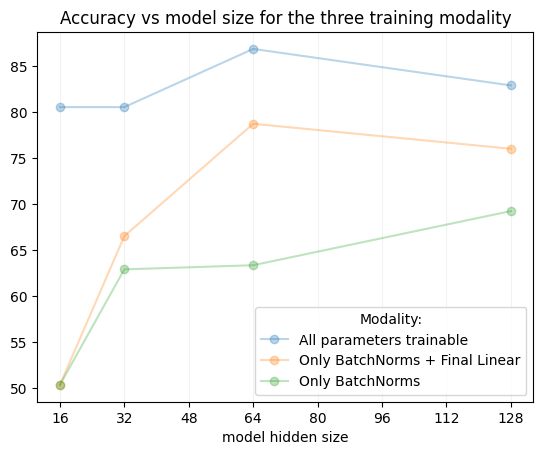

In [27]:

NAME = {}
NAME["ALL"] = "All parameters trainable"
NAME["only_BN"] = "Only BatchNorms"
NAME["only_BN_FC"] = "Only BatchNorms + Final Linear"

size_0 = 16
size_last = 128


for mode in model_size_history.keys():
    name = NAME[mode]
    x = model_size_history[mode]["HIDDEN_CHANNEL_LIST"]
    y = model_size_history[mode]["TEST_ACCURACY"]
    plt.plot(x, y, 'o-', alpha=0.3, label = name)
    plt.legend()
    
plt.xlabel("model hidden size")
plt.xticks(list(range(size_0, size_last + size_0 ,size_0)))
plt.grid(axis='x', color='0.95')
plt.legend(title='Modality:')
plt.title('Accuracy vs model size for the three training modality')
plt.show()

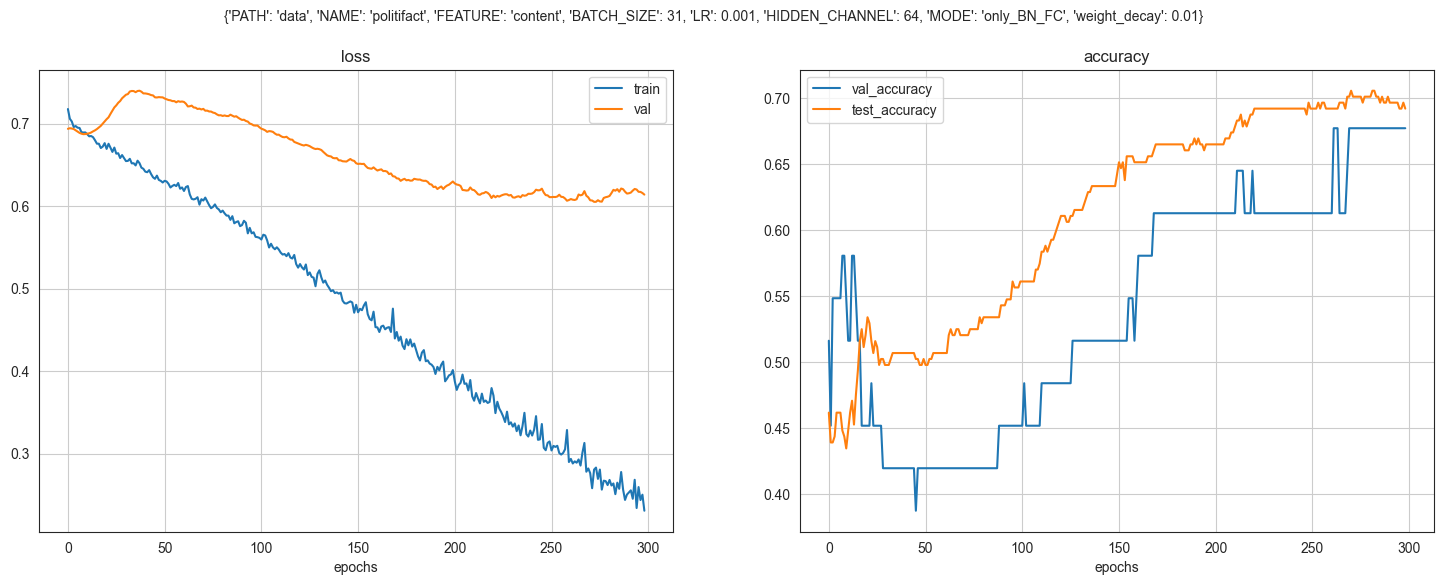

In [444]:
plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc)

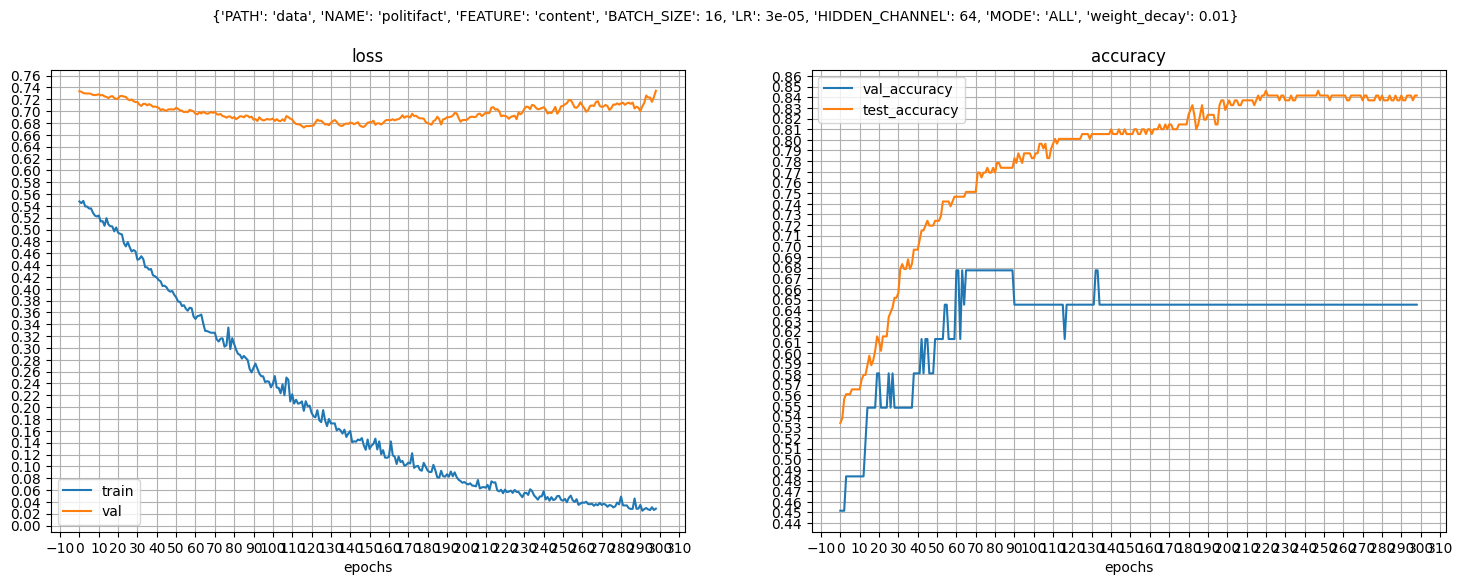

In [344]:
plots(loss_train_history,loss_valid_history,acc__valid_history,acc__test__history,model_desc)

## Distribution of BatchNorm beta parameter after training.  

In [446]:
histories[args.MODE]["bn1"] = [p.detach().numpy() for p in model.norm1.parameters()]
histories[args.MODE]["bn2"] = [p.detach().numpy() for p in model.norm2.parameters()]

Namespace(PATH='data', NAME='politifact', FEATURE='content', BATCH_SIZE=31, LR=0.001, HIDDEN_CHANNEL=64, MODE='only_BN_FC', weight_decay=0.01)


Text(0.5, 0, 'weights values')

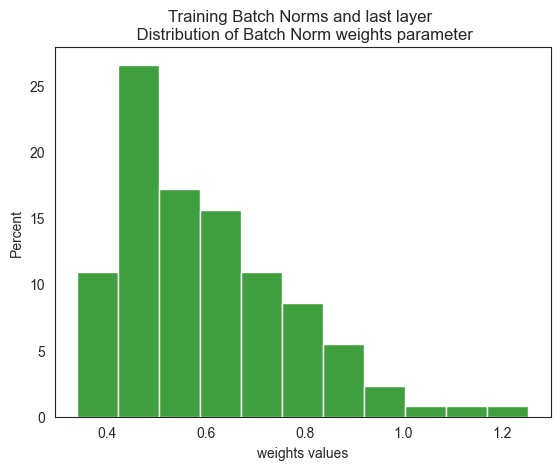

In [447]:
print(args)
bn1_weight = histories[args.MODE]["bn1"][0]
bn2_weight = histories[args.MODE]["bn2"][0]
title = "Training Batch Norms and last layer \n Distribution of Batch Norm weights parameter"
sns.set_style("white")
ax = sns.histplot(np.concatenate([bn1_weight,bn2_weight]), stat="percent", color = "green")
ax.set_title(title)
ax.set_xlabel("weights values")

Namespace(PATH='data', NAME='politifact', FEATURE='content', BATCH_SIZE=31, LR=0.001, HIDDEN_CHANNEL=64, MODE='only_BN', weight_decay=0.01)


Text(0.5, 0, 'weights values')

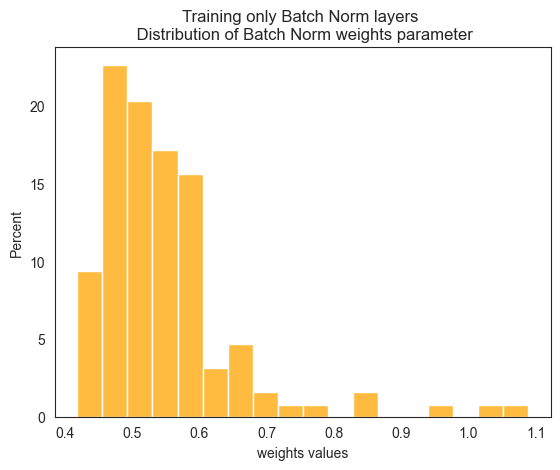

In [428]:
print(args)
bn1_weight = histories[args.MODE]["bn1"][0]
bn2_weight = histories[args.MODE]["bn2"][0]
title = "Training only Batch Norm layers \n Distribution of Batch Norm weights parameter"
sns.set_style("white")
ax = sns.histplot(np.concatenate([bn1_weight,bn2_weight]), stat="percent", color = "orange")
ax.set_title(title)
ax.set_xlabel("weights values")

Namespace(PATH='data', NAME='politifact', FEATURE='content', BATCH_SIZE=16, LR=3e-05, HIDDEN_CHANNEL=64, MODE='ALL', weight_decay=0.01)


Text(0.5, 0, 'weights values')

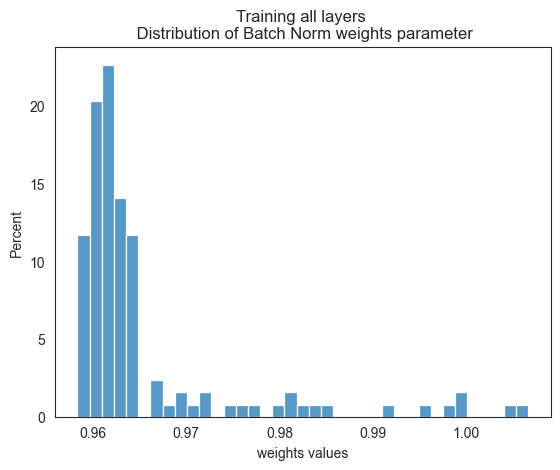

In [367]:
print(args)
bn1_weight = histories[args.MODE]["bn1"][0]
bn2_weight = histories[args.MODE]["bn2"][0]
title = "Training all layers \n Distribution of Batch Norm weights parameter"
sns.set_style("white")
ax = sns.histplot(np.concatenate([bn1_weight,bn2_weight]), stat="percent")
ax.set_title(title)
ax.set_xlabel("weights values")